In [1]:
import pandas as pd
import numpy as np
from tabulate import tabulate
from sklearn.preprocessing import MinMaxScaler
import pickle
from sklearn.model_selection import train_test_split


In [2]:
# ratings_gvkeys = pd.read_csv("ratings_gvkeys.csv")
# ratings_gvkeys.head()

In [3]:
# ratings_gvkeys =  ratings_gvkeys[['gvkey','spcsrc','tic','datadate']]
# # Ensure trd_exctn_dt is in datetime format
# ratings_gvkeys['datadate'] = pd.to_datetime(ratings_gvkeys['datadate'])

# ratings_gvkeys

In [4]:
model_data = pd.read_pickle("final_merged_data_daily_ver1.pkl")
model_data.head()

,cusip_id,trd_exctn_dt,bond_sym_id,company_symbol,entrd_vol_qt,rptd_pr,yld_pt,maturity,gross_spread,offering_amt,offering_date,offering_price,offering_yield,principal_amt,coupon
0,00037BAB8,2019-03-20,ABB3852125,ABB,75000.0,99.96200,2.887133,2022-05-08,4.5,1250000.0,2012-05-03,97.833,3.12905,1000.0,2.875
1,00037BAB8,2019-03-21,ABB3852125,ABB,1305000.0,100.36900,2.750151,2022-05-08,4.5,1250000.0,2012-05-03,97.833,3.12905,1000.0,2.875
2,00037BAB8,2019-03-22,ABB3852125,ABB,1170000.0,100.30700,2.770905,2022-05-08,4.5,1250000.0,2012-05-03,97.833,3.12905,1000.0,2.875
3,00037BAB8,2019-03-25,ABB3852125,ABB,600000.0,100.78626,2.609905,2022-05-08,4.5,1250000.0,2012-05-03,97.833,3.12905,1000.0,2.875
4,00037BAB8,2019-03-26,ABB3852125,ABB,100000.0,100.66900,2.649010,2022-05-08,4.5,1250000.0,2012-05-03,97.833,3.12905,1000.0,2.875


In [5]:
model_data['trd_exctn_dt'].describe()

/var/tmp/ipykernel_634206/255980566.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  model_data['trd_exctn_dt'].describe()


count                 1345400
unique                   1580
top       2020-03-02 00:00:00
freq                     1799
first     2017-01-04 00:00:00
last      2022-09-01 00:00:00
Name: trd_exctn_dt, dtype: object

In [6]:
model_data = model_data[model_data['offering_yield'].notna()]
model_data.shape

(1325100, 15)

In [7]:
model_data['cusip_id'].value_counts().value_counts()

700    1893
Name: cusip_id, dtype: int64

In [8]:
# TRAINING DATA PRE PROCESSING 

model_data['offering_date'] = pd.to_datetime(model_data['offering_date'])
model_data['maturity'] = pd.to_datetime(model_data['maturity'])

# Step 2: Extract the offering year and month
model_data['offering_year'] = model_data['offering_date'].dt.year
model_data['offering_month'] = model_data['offering_date'].dt.month
model_data['maturity_year'] = model_data['maturity'].dt.year
model_data['maturity_month'] = model_data['maturity'].dt.month

# Step 3: Drop the original 'offering_date' column
model_data.drop(columns=['offering_date','maturity','gross_spread'], axis=1, inplace=True)

model_data.head(2)

,cusip_id,trd_exctn_dt,bond_sym_id,company_symbol,entrd_vol_qt,rptd_pr,yld_pt,offering_amt,offering_price,offering_yield,principal_amt,coupon,offering_year,offering_month,maturity_year,maturity_month
0,00037BAB8,2019-03-20,ABB3852125,ABB,75000.0,99.962,2.887133,1250000.0,97.833,3.12905,1000.0,2.875,2012,5,2022,5
1,00037BAB8,2019-03-21,ABB3852125,ABB,1305000.0,100.369,2.750151,1250000.0,97.833,3.12905,1000.0,2.875,2012,5,2022,5


In [9]:
import pandas as pd

# Ensure trd_exctn_dt is in datetime format
model_data['trd_exctn_dt'] = pd.to_datetime(model_data['trd_exctn_dt'])

# Extract year and month
model_data['exn_year'] = model_data['trd_exctn_dt'].dt.year
model_data['exn_month'] = model_data['trd_exctn_dt'].dt.month
model_data['exn_day'] = model_data['trd_exctn_dt'].dt.day
model_data

,cusip_id,trd_exctn_dt,bond_sym_id,company_symbol,entrd_vol_qt,rptd_pr,yld_pt,offering_amt,offering_price,offering_yield,principal_amt,coupon,offering_year,offering_month,maturity_year,maturity_month,exn_year,exn_month,exn_day
0,00037BAB8,2019-03-20,ABB3852125,ABB,75000.0,99.96200,2.887133,1250000.0,97.833,3.12905,1000.0,2.875,2012,5,2022,5,2019,3,20
1,00037BAB8,2019-03-21,ABB3852125,ABB,1305000.0,100.36900,2.750151,1250000.0,97.833,3.12905,1000.0,2.875,2012,5,2022,5,2019,3,21
2,00037BAB8,2019-03-22,ABB3852125,ABB,1170000.0,100.30700,2.770905,1250000.0,97.833,3.12905,1000.0,2.875,2012,5,2022,5,2019,3,22
3,00037BAB8,2019-03-25,ABB3852125,ABB,600000.0,100.78626,2.609905,1250000.0,97.833,3.12905,1000.0,2.875,2012,5,2022,5,2019,3,25
4,00037BAB8,2019-03-26,ABB3852125,ABB,100000.0,100.66900,2.649010,1250000.0,97.833,3.12905,1000.0,2.875,2012,5,2022,5,2019,3,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1345395,98978VAN3,2022-08-26,PFE4666688,PFE,210000.0,98.38700,4.208056,500000.0,99.811,3.92303,1000.0,3.900,2018,8,2028,8,2022,8,26
1345396,98978VAN3,2022-08-29,PFE4666688,PFE,1500000.0,98.03600,4.276044,500000.0,99.811,3.92303,1000.0,3.900,2018,8,2028,8,2022,8,29
1345397,98978VAN3,2022-08-30,PFE4666688,PFE,125000.0,98.04100,4.275075,500000.0,99.811,3.92303,1000.0,3.900,2018,8,2028,8,2022,8,30
1345398,98978VAN3,2022-08-31,PFE4666688,PFE,480000.0,97.87200,4.308006,500000.0,99.811,3.92303,1000.0,3.900,2018,8,2028,8,2022,8,31


In [10]:


# ratings = ratings_gvkeys.copy()


In [11]:
numerical_columns = ['entrd_vol_qt', 'rptd_pr', 'yld_pt', 'offering_amt', 'offering_price',
       'offering_yield', 'principal_amt', 'coupon', 'offering_year',
       'offering_month', 'maturity_year', 'maturity_month']


model_data[numerical_columns] = model_data[numerical_columns].astype(float)

# Outlier Handling

In [12]:
def find_outliers(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    mask = ((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR)))
    return mask

In [13]:
def handle_outliers_per_bond(df, columns_to_check):
    def find_and_replace_outliers(column):
        # Handle initial NaNs
        column.fillna(method='ffill', inplace=True)

        # Outlier detection
        Q1 = column.quantile(0.25)
        Q3 = column.quantile(0.75)
        IQR = Q3 - Q1
        if column.name == 'yld_pt':
            lower_bound = Q1 - 1.0 * IQR
            upper_bound = Q3 + 1.0 * IQR
        else:
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
        outliers_mask = (column < lower_bound) | (column > upper_bound)
        column[outliers_mask] = None

        # Replace NaNs with previous non-NaN values
        column.fillna(method='ffill', inplace=True)

        # Handle any remaining NaNs (e.g., if the first value was an outlier)
        column.fillna(method='bfill', inplace=True)

        return column
    
    # Apply to specified columns
    for col in columns_to_check:
        df[col] = df.groupby('cusip_id')[col].apply(find_and_replace_outliers)
    
    return df

# Usage remains the same
columns_to_check = ['entrd_vol_qt', 'rptd_pr', 'yld_pt']
model_data = handle_outliers_per_bond(model_data, columns_to_check)


/var/tmp/ipykernel_634206/3852172101.py:29: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df[col] = df.groupby('cusip_id')[col].apply(find_and_replace_outliers)
/var/tmp/ipykernel_634206/3852172101.py:29: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df[col] = df.groupby('cusip_id')[col].apply(f

In [14]:
# Check for NaNs in the entire DataFrame
if model_data.isna().any().any():
    print("There are NaNs in the DataFrame.")

# Check for NaNs in specific columns
columns_to_check = ['entrd_vol_qt', 'rptd_pr', 'yld_pt']
if model_data[columns_to_check].isna().any().any():
    print("There are NaNs in the specified columns.")

# Get the count of NaNs in each column
na_counts = model_data.isna().sum()
print(na_counts)


cusip_id          0
trd_exctn_dt      0
bond_sym_id       0
company_symbol    0
entrd_vol_qt      0
rptd_pr           0
yld_pt            0
offering_amt      0
offering_price    0
offering_yield    0
principal_amt     0
coupon            0
offering_year     0
offering_month    0
maturity_year     0
maturity_month    0
exn_year          0
exn_month         0
exn_day           0
dtype: int64


In [15]:
model_data.columns

Index(['cusip_id', 'trd_exctn_dt', 'bond_sym_id', 'company_symbol',
       'entrd_vol_qt', 'rptd_pr', 'yld_pt', 'offering_amt', 'offering_price',
       'offering_yield', 'principal_amt', 'coupon', 'offering_year',
       'offering_month', 'maturity_year', 'maturity_month', 'exn_year',
       'exn_month', 'exn_day'],
      dtype='object')

In [16]:
model_data.to_pickle('model_data_itr2_wogvkeys.pkl')

In [17]:
model_data.columns

Index(['cusip_id', 'trd_exctn_dt', 'bond_sym_id', 'company_symbol',
       'entrd_vol_qt', 'rptd_pr', 'yld_pt', 'offering_amt', 'offering_price',
       'offering_yield', 'principal_amt', 'coupon', 'offering_year',
       'offering_month', 'maturity_year', 'maturity_month', 'exn_year',
       'exn_month', 'exn_day'],
      dtype='object')

In [18]:
# unique_company_symbols = model_data['company_symbol'].unique()
# print(unique_company_symbols)


In [19]:
# unique_company_symbols = model_data['company_symbol'].unique()

# # Join the unique symbols with a space separator
# company_symbols_string = ' '.join(unique_company_symbols.astype(str))

# # Write to a text file
# with open('company_codes.txt', 'w') as file:
#     file.write(company_symbols_string)


In [20]:
# model_data = pd.read_pickle('model_data_itr2_wogvkeys.pkl')

# Company Financials

In [21]:
model_data['cusip_id'].nunique()

1893

In [22]:
# https://wrds-www.wharton.upenn.edu/pages/get-data/compustat-capital-iq-standard-poors/compustat/north-america-daily/ratings/

# https://wrds-www.wharton.upenn.edu/pages/get-data/center-research-security-prices-crsp/annual-update/crspcompustat-merged/fundamentals-quarterly/


company_deets = pd.read_csv(r'company_deets_tic.zip',compression = 'zip')

In [23]:
company_deets.columns

Index(['GVKEY', 'datadate', 'fyearq', 'fqtr', 'indfmt', 'consol', 'popsrc',
       'datafmt', 'tic', 'conm', 'curcdq', 'datacqtr', 'datafqtr', 'actq',
       'ceqq', 'chq', 'dlcq', 'dpactq', 'findlcq', 'uceqq', 'costat', 'prchq',
       'prclq', 'sic', 'spcsrc'],
      dtype='object')

important links 
https://wrds-www.wharton.upenn.edu/pages/get-data/financial-ratios-suite-wrds/financial-ratios/financial-ratios-firm-level-by-wrds-beta/

In [24]:
company_deets.head()

,GVKEY,datadate,fyearq,fqtr,indfmt,consol,popsrc,datafmt,tic,conm,...,chq,dlcq,dpactq,findlcq,uceqq,costat,prchq,prclq,sic,spcsrc
0,1078,2016-06-30,2016,2,INDL,C,D,STD,ABT,ABBOTT LABORATORIES,...,2578.0,2896.0,6886.0,NaN,NaN,A,44.58,36.76,3845,B+
1,1078,2016-09-30,2016,3,INDL,C,D,STD,ABT,ABBOTT LABORATORIES,...,2500.0,2535.0,6718.0,NaN,NaN,A,45.79,39.16,3845,B+
2,1078,2016-12-31,2016,4,INDL,C,D,STD,ABT,ABBOTT LABORATORIES,...,18620.0,1325.0,6661.0,NaN,NaN,A,43.78,37.38,3845,B+
3,1078,2017-03-31,2017,1,INDL,C,D,STD,ABT,ABBOTT LABORATORIES,...,8706.0,210.0,6907.0,NaN,NaN,A,45.84,38.34,3845,B+
4,1078,2017-06-30,2017,2,INDL,C,D,STD,ABT,ABBOTT LABORATORIES,...,9675.0,221.0,7190.0,NaN,NaN,A,49.59,42.31,3845,B+


In [25]:
company_deets['tic'].nunique()

390

In [26]:
# Ensure trd_exctn_dt is in datetime format
company_deets['datadate'] = pd.to_datetime(company_deets['datadate'])

latest_c_deets = company_deets[company_deets['datadate'].dt.year >= 2016]

latest_c_deets


,GVKEY,datadate,fyearq,fqtr,indfmt,consol,popsrc,datafmt,tic,conm,...,chq,dlcq,dpactq,findlcq,uceqq,costat,prchq,prclq,sic,spcsrc
0,1078,2016-06-30,2016,2,INDL,C,D,STD,ABT,ABBOTT LABORATORIES,...,2578.0,2896.0,6886.0,NaN,NaN,A,44.58,36.76,3845,B+
1,1078,2016-09-30,2016,3,INDL,C,D,STD,ABT,ABBOTT LABORATORIES,...,2500.0,2535.0,6718.0,NaN,NaN,A,45.79,39.16,3845,B+
2,1078,2016-12-31,2016,4,INDL,C,D,STD,ABT,ABBOTT LABORATORIES,...,18620.0,1325.0,6661.0,NaN,NaN,A,43.78,37.38,3845,B+
3,1078,2017-03-31,2017,1,INDL,C,D,STD,ABT,ABBOTT LABORATORIES,...,8706.0,210.0,6907.0,NaN,NaN,A,45.84,38.34,3845,B+
4,1078,2017-06-30,2017,2,INDL,C,D,STD,ABT,ABBOTT LABORATORIES,...,9675.0,221.0,7190.0,NaN,NaN,A,49.59,42.31,3845,B+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11091,294524,2022-06-30,2022,2,INDL,C,D,STD,LYB,LYONDELLBASELL INDUSTRIES NV,...,1057.0,405.0,7923.0,NaN,NaN,A,117.22,83.50,2820,B+
11092,294524,2022-09-30,2022,3,INDL,C,D,STD,LYB,LYONDELLBASELL INDUSTRIES NV,...,1480.0,439.0,7817.0,NaN,NaN,A,92.52,71.46,2820,B+
11093,294524,2022-12-31,2022,4,INDL,C,D,STD,LYB,LYONDELLBASELL INDUSTRIES NV,...,2151.0,1125.0,8337.0,NaN,NaN,A,89.60,75.24,2820,B+
11094,294524,2023-03-31,2023,1,INDL,C,D,STD,LYB,LYONDELLBASELL INDUSTRIES NV,...,1790.0,775.0,8729.0,NaN,NaN,A,101.30,81.24,2820,B+


In [27]:
latest_c_deets.columns

Index(['GVKEY', 'datadate', 'fyearq', 'fqtr', 'indfmt', 'consol', 'popsrc',
       'datafmt', 'tic', 'conm', 'curcdq', 'datacqtr', 'datafqtr', 'actq',
       'ceqq', 'chq', 'dlcq', 'dpactq', 'findlcq', 'uceqq', 'costat', 'prchq',
       'prclq', 'sic', 'spcsrc'],
      dtype='object')

In [28]:

model_data['company_symbol'] = model_data['company_symbol'].astype(str)
latest_c_deets['tic'] = latest_c_deets['tic'].astype(str)

# Extract the year and month from 'datadate'
latest_c_deets['year'] = latest_c_deets['datadate'].dt.year
latest_c_deets['month'] = latest_c_deets['datadate'].dt.month




In [29]:


# Create column for the quarter of trd_exctn_dt
model_data['trd_quarter'] = model_data['trd_exctn_dt'].dt.quarter

# Create columns for the previous quarter and its year
def get_previous_quarter(year, quarter):
    if quarter == 1:
        return year - 1, 4
    else:
        return year, quarter - 1

model_data['match_year'], model_data['match_quarter'] = zip(*model_data.apply(lambda x: get_previous_quarter(x['trd_exctn_dt'].year, x['trd_quarter']), axis=1))




In [30]:
model_data

,cusip_id,trd_exctn_dt,bond_sym_id,company_symbol,entrd_vol_qt,rptd_pr,yld_pt,offering_amt,offering_price,offering_yield,...,offering_year,offering_month,maturity_year,maturity_month,exn_year,exn_month,exn_day,trd_quarter,match_year,match_quarter
0,00037BAB8,2019-03-20,ABB3852125,ABB,75000.0,99.96200,2.887133,1250000.0,97.833,3.12905,...,2012.0,5.0,2022.0,5.0,2019,3,20,1,2018,4
1,00037BAB8,2019-03-21,ABB3852125,ABB,1305000.0,100.36900,2.750151,1250000.0,97.833,3.12905,...,2012.0,5.0,2022.0,5.0,2019,3,21,1,2018,4
2,00037BAB8,2019-03-22,ABB3852125,ABB,1170000.0,100.30700,2.770905,1250000.0,97.833,3.12905,...,2012.0,5.0,2022.0,5.0,2019,3,22,1,2018,4
3,00037BAB8,2019-03-25,ABB3852125,ABB,600000.0,100.78626,2.609905,1250000.0,97.833,3.12905,...,2012.0,5.0,2022.0,5.0,2019,3,25,1,2018,4
4,00037BAB8,2019-03-26,ABB3852125,ABB,100000.0,100.66900,2.649010,1250000.0,97.833,3.12905,...,2012.0,5.0,2022.0,5.0,2019,3,26,1,2018,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1345395,98978VAN3,2022-08-26,PFE4666688,PFE,210000.0,98.38700,4.208056,500000.0,99.811,3.92303,...,2018.0,8.0,2028.0,8.0,2022,8,26,3,2022,2
1345396,98978VAN3,2022-08-29,PFE4666688,PFE,1500000.0,98.03600,4.276044,500000.0,99.811,3.92303,...,2018.0,8.0,2028.0,8.0,2022,8,29,3,2022,2
1345397,98978VAN3,2022-08-30,PFE4666688,PFE,125000.0,98.04100,4.275075,500000.0,99.811,3.92303,...,2018.0,8.0,2028.0,8.0,2022,8,30,3,2022,2
1345398,98978VAN3,2022-08-31,PFE4666688,PFE,480000.0,97.87200,4.308006,500000.0,99.811,3.92303,...,2018.0,8.0,2028.0,8.0,2022,8,31,3,2022,2


In [31]:

latest_c_deets['fqtr'] = latest_c_deets['fqtr'].astype(int)

# Merge the dataframes
merged_data = pd.merge(model_data, latest_c_deets, left_on=['company_symbol', 'match_year', 'match_quarter'], right_on=['tic', 'fyearq', 'fqtr'], how='left')

# Cleanup: If necessary, drop duplicated columns or rename for clarity.

In [32]:
latest_c_deets['tic'].nunique()

390

In [33]:
merged_data['company_symbol'].nunique()

520

In [34]:
latest_c_deets.columns

Index(['GVKEY', 'datadate', 'fyearq', 'fqtr', 'indfmt', 'consol', 'popsrc',
       'datafmt', 'tic', 'conm', 'curcdq', 'datacqtr', 'datafqtr', 'actq',
       'ceqq', 'chq', 'dlcq', 'dpactq', 'findlcq', 'uceqq', 'costat', 'prchq',
       'prclq', 'sic', 'spcsrc', 'year', 'month'],
      dtype='object')

In [35]:
merged_data['datadate'].isna().value_counts()

False    1076949
True      248151
Name: datadate, dtype: int64

In [36]:
merged_data = merged_data[merged_data['datadate'].notna()]
merged_data.shape

(1076949, 49)

In [37]:
merged_data['cusip_id'].nunique()

1567

In [38]:
merged_data['company_symbol'].nunique()

389

In [53]:
merged_data.columns

Index(['cusip_id', 'trd_exctn_dt', 'bond_sym_id', 'company_symbol',
       'entrd_vol_qt', 'rptd_pr', 'yld_pt', 'offering_amt', 'offering_price',
       'offering_yield', 'principal_amt', 'coupon', 'offering_year',
       'offering_month', 'maturity_year', 'maturity_month', 'exn_year',
       'exn_month', 'exn_day', 'trd_quarter', 'match_year', 'match_quarter',
       'GVKEY', 'datadate', 'fyearq', 'fqtr', 'indfmt', 'consol', 'popsrc',
       'datafmt', 'tic', 'conm', 'curcdq', 'datacqtr', 'datafqtr', 'actq',
       'ceqq', 'chq', 'dlcq', 'dpactq', 'findlcq', 'uceqq', 'costat', 'prchq',
       'prclq', 'sic', 'spcsrc', 'year', 'month'],
      dtype='object')

In [39]:

empty_row_percentages = (merged_data.isnull().sum() / len(merged_data)) * 100

# Print the percentage of empty rows in each column
for column, percentage in empty_row_percentages.iteritems():
    print(f"Percentage of empty rows in {column}: {percentage}%")
    # print(f"Unique values {column}: {company_deets[column].nunique()}")


Percentage of empty rows in cusip_id: 0.0%
Percentage of empty rows in trd_exctn_dt: 0.0%
Percentage of empty rows in bond_sym_id: 0.0%
Percentage of empty rows in company_symbol: 0.0%
Percentage of empty rows in entrd_vol_qt: 0.0%
Percentage of empty rows in rptd_pr: 0.0%
Percentage of empty rows in yld_pt: 0.0%
Percentage of empty rows in offering_amt: 0.0%
Percentage of empty rows in offering_price: 0.0%
Percentage of empty rows in offering_yield: 0.0%
Percentage of empty rows in principal_amt: 0.0%
Percentage of empty rows in coupon: 0.0%
Percentage of empty rows in offering_year: 0.0%
Percentage of empty rows in offering_month: 0.0%
Percentage of empty rows in maturity_year: 0.0%
Percentage of empty rows in maturity_month: 0.0%
Percentage of empty rows in exn_year: 0.0%
Percentage of empty rows in exn_month: 0.0%
Percentage of empty rows in exn_day: 0.0%
Percentage of empty rows in trd_quarter: 0.0%
Percentage of empty rows in match_year: 0.0%
Percentage of empty rows in match_qua

/var/tmp/ipykernel_634206/172658158.py:4: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, percentage in empty_row_percentages.iteritems():


In [40]:
merged_data.columns

Index(['cusip_id', 'trd_exctn_dt', 'bond_sym_id', 'company_symbol',
       'entrd_vol_qt', 'rptd_pr', 'yld_pt', 'offering_amt', 'offering_price',
       'offering_yield', 'principal_amt', 'coupon', 'offering_year',
       'offering_month', 'maturity_year', 'maturity_month', 'exn_year',
       'exn_month', 'exn_day', 'trd_quarter', 'match_year', 'match_quarter',
       'GVKEY', 'datadate', 'fyearq', 'fqtr', 'indfmt', 'consol', 'popsrc',
       'datafmt', 'tic', 'conm', 'curcdq', 'datacqtr', 'datafqtr', 'actq',
       'ceqq', 'chq', 'dlcq', 'dpactq', 'findlcq', 'uceqq', 'costat', 'prchq',
       'prclq', 'sic', 'spcsrc', 'year', 'month'],
      dtype='object')

In [41]:
merged_data.shape

(1076949, 49)

In [42]:
# Removing rows without ratings

merged_data = merged_data[merged_data['spcsrc'].notna()]
merged_data.shape

(944620, 49)

In [43]:


# Count the number of rows for each 'cusip_id'
cusip_counts = merged_data['cusip_id'].value_counts()

# Get the 'cusip_id' values that have at least 250 rows
valid_cusip_ids = cusip_counts[cusip_counts >= 700].index

# Filter the dataframe to include only the valid 'cusip_id' values
merged_data = merged_data[merged_data['cusip_id'].isin(valid_cusip_ids)]

# Sort the dataframe by date in descending order within each 'cusip_id' group
merged_data.sort_values(by='trd_exctn_dt', ascending=False, inplace=True)

# Group the dataframe by 'cusip_id' and select the top 250 rows for each group
training_data = merged_data.groupby('cusip_id').head(700)

training_data.shape


(926100, 49)

In [44]:
training_data['cusip_id'].value_counts().value_counts()

700    1323
Name: cusip_id, dtype: int64

In [45]:
columns_to_remove = ['indfmt', 'consol', 'popsrc', 'datafmt', 'curcdq', 'datacqtr', 'datafqtr', 'costat', 'prclq','fqtr','findlcq','uceqq','dpactq','actq']

training_data = training_data.drop(columns=columns_to_remove)

In [46]:
training_data.shape

(926100, 35)

In [47]:
training_data['cusip_id'].value_counts().value_counts()

700    1323
Name: cusip_id, dtype: int64

# Imputation

In [48]:
training_data.shape

(926100, 35)

In [49]:

empty_row_percentages = (training_data.isnull().sum() / len(training_data)) * 100

# Print the percentage of empty rows in each column
for column, percentage in empty_row_percentages.iteritems():
    print(f"Percentage of empty rows in {column}: {percentage}%")
    # print(f"Unique values {column}: {company_deets[column].nunique()}")


Percentage of empty rows in cusip_id: 0.0%
Percentage of empty rows in trd_exctn_dt: 0.0%
Percentage of empty rows in bond_sym_id: 0.0%
Percentage of empty rows in company_symbol: 0.0%
Percentage of empty rows in entrd_vol_qt: 0.0%
Percentage of empty rows in rptd_pr: 0.0%
Percentage of empty rows in yld_pt: 0.0%
Percentage of empty rows in offering_amt: 0.0%
Percentage of empty rows in offering_price: 0.0%
Percentage of empty rows in offering_yield: 0.0%
Percentage of empty rows in principal_amt: 0.0%
Percentage of empty rows in coupon: 0.0%
Percentage of empty rows in offering_year: 0.0%
Percentage of empty rows in offering_month: 0.0%
Percentage of empty rows in maturity_year: 0.0%
Percentage of empty rows in maturity_month: 0.0%
Percentage of empty rows in exn_year: 0.0%
Percentage of empty rows in exn_month: 0.0%
Percentage of empty rows in exn_day: 0.0%
Percentage of empty rows in trd_quarter: 0.0%
Percentage of empty rows in match_year: 0.0%
Percentage of empty rows in match_qua

/var/tmp/ipykernel_634206/4063504821.py:4: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, percentage in empty_row_percentages.iteritems():


In [50]:
# List of columns to impute
columns_to_impute = ["ceqq", "chq", "dlcq", "prchq"]

# Apply the group-wise mean imputation
for column in columns_to_impute:
    training_data[column] = training_data.groupby('tic')[column].transform(lambda group: group.fillna(group.mean()))

# Apply the global mean imputation to any remaining missing values
for column in columns_to_impute:
    training_data[column].fillna(training_data[column].mean(), inplace=True)


In [51]:

empty_row_percentages = (training_data.isnull().sum() / len(training_data)) * 100

# Print the percentage of empty rows in each column
for column, percentage in empty_row_percentages.iteritems():
    print(f"Percentage of empty rows in {column}: {percentage}%")
    # print(f"Unique values {column}: {company_deets[column].nunique()}")


Percentage of empty rows in cusip_id: 0.0%
Percentage of empty rows in trd_exctn_dt: 0.0%
Percentage of empty rows in bond_sym_id: 0.0%
Percentage of empty rows in company_symbol: 0.0%
Percentage of empty rows in entrd_vol_qt: 0.0%
Percentage of empty rows in rptd_pr: 0.0%
Percentage of empty rows in yld_pt: 0.0%
Percentage of empty rows in offering_amt: 0.0%
Percentage of empty rows in offering_price: 0.0%
Percentage of empty rows in offering_yield: 0.0%
Percentage of empty rows in principal_amt: 0.0%
Percentage of empty rows in coupon: 0.0%
Percentage of empty rows in offering_year: 0.0%
Percentage of empty rows in offering_month: 0.0%
Percentage of empty rows in maturity_year: 0.0%
Percentage of empty rows in maturity_month: 0.0%
Percentage of empty rows in exn_year: 0.0%
Percentage of empty rows in exn_month: 0.0%
Percentage of empty rows in exn_day: 0.0%
Percentage of empty rows in trd_quarter: 0.0%
Percentage of empty rows in match_year: 0.0%
Percentage of empty rows in match_qua

/var/tmp/ipykernel_634206/4063504821.py:4: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, percentage in empty_row_percentages.iteritems():


In [52]:
training_data.shape

(926100, 35)

In [54]:
# PLOTS

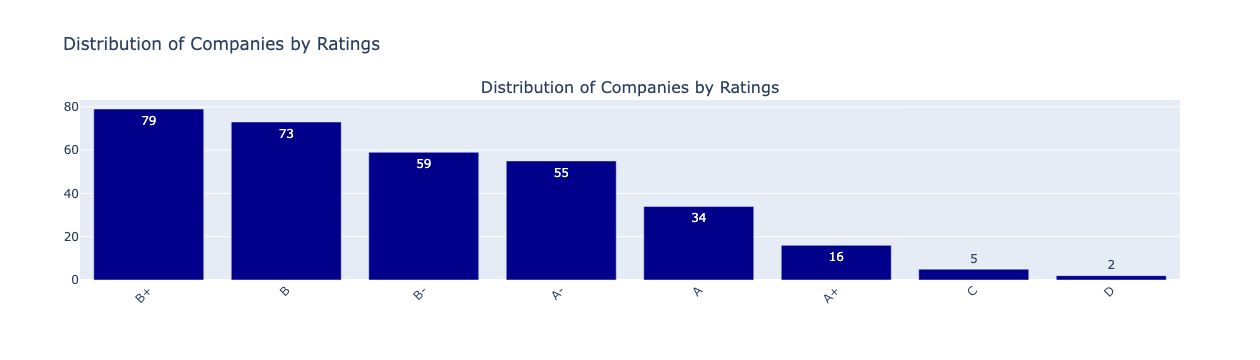

In [56]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Sample data read, replace this with your data file path
df = training_data.copy()

# Group data by 'spcsrc' and count unique 'tic' (company identifier)
grouped_by_rating = df.drop_duplicates(subset='tic').groupby('spcsrc').size().sort_values(ascending=False)

# Create the plot
fig = make_subplots(rows=1, cols=1, subplot_titles=('Distribution of Companies by Ratings',))

fig.add_trace(go.Bar(x=grouped_by_rating.index, y=grouped_by_rating.values,
                     text=grouped_by_rating.values, textposition='auto',marker_color='#00008B'))

# Update layout for better appearance
fig.update_layout(showlegend=False, title_text="Distribution of Companies by Ratings", 
                  barmode='stack', xaxis_tickangle=-45)

# Save the plot as an HTML file (or other formats as needed)
# fig.write_html('ratings_distribution.html')

# Show the plot in an interactive notebook or script
fig.show()


# Data Split

In [53]:
df = training_data.sort_values('trd_exctn_dt')

df.drop(columns=['trd_exctn_dt', 'bond_sym_id', 'company_symbol','conm','tic',
                     'match_year', 'match_quarter', 'GVKEY', 'year', 'month','datadate'], inplace=True)

df['spcsrc'] = df['spcsrc'].astype(str)
# Step 2: Perform a stratified time-based split for each bond
train_df = pd.DataFrame()
val_df = pd.DataFrame()
test_df = pd.DataFrame()

unique_bonds = df['cusip_id'].unique()
for bond_id in unique_bonds:
    bond_data = df[df['cusip_id'] == bond_id]
    train_data, test_data = train_test_split(bond_data, test_size=0.4, shuffle=False)
    val_data, test_data = train_test_split(test_data, test_size=0.5, shuffle=False)

    train_df = pd.concat([train_df, train_data])
    val_df = pd.concat([val_df, val_data])
    test_df = pd.concat([test_df, test_data])


In [54]:
X_train, y_train = train_df.copy(),train_df['yld_pt']
X_valid, y_valid = val_df.copy(), val_df['yld_pt']
X_test, y_test = test_df.copy(), test_df['yld_pt']

In [55]:
dfs = [train_df,val_df,test_df]

for d in dfs:
    print(d.shape)
    print(d['cusip_id'].nunique())
    print(d['cusip_id'].value_counts().value_counts())
    # print(d['company_symbol'].nunique())
    # print(d.head(5))
    print("--------")

(555660, 24)
1323
420    1323
Name: cusip_id, dtype: int64
--------
(185220, 24)
1323
140    1323
Name: cusip_id, dtype: int64
--------
(185220, 24)
1323
140    1323
Name: cusip_id, dtype: int64
--------


# Encoding

In [ ]:
train_df.columns

In [57]:

train_df.head()

,cusip_id,entrd_vol_qt,rptd_pr,yld_pt,offering_amt,offering_price,offering_yield,principal_amt,coupon,offering_year,...,exn_month,exn_day,trd_quarter,fyearq,ceqq,chq,dlcq,prchq,sic,spcsrc
534800,31620MAS5,500000.0,97.6700,2.792993,750000.0,99.986,2.25297,1000.0,2.25,2016.0,...,1,4,1,2016.0,9741.0,683.0,332.0,79.23,7374.0,B-
534801,31620MAS5,158000.0,97.8096,2.760330,750000.0,99.986,2.25297,1000.0,2.25,2016.0,...,1,5,1,2016.0,9741.0,683.0,332.0,79.23,7374.0,B-
534802,31620MAS5,158000.0,97.8460,2.752034,750000.0,99.986,2.25297,1000.0,2.25,2016.0,...,1,6,1,2016.0,9741.0,683.0,332.0,79.23,7374.0,B-
534803,31620MAS5,750000.0,98.1570,2.678993,750000.0,99.986,2.25297,1000.0,2.25,2016.0,...,1,9,1,2016.0,9741.0,683.0,332.0,79.23,7374.0,B-
534804,31620MAS5,342000.0,97.8400,2.754042,750000.0,99.986,2.25297,1000.0,2.25,2016.0,...,1,10,1,2016.0,9741.0,683.0,332.0,79.23,7374.0,B-


In [58]:
train_df.dtypes

cusip_id           object
entrd_vol_qt      float64
rptd_pr           float64
yld_pt            float64
offering_amt      float64
offering_price    float64
offering_yield    float64
principal_amt     float64
coupon            float64
offering_year     float64
offering_month    float64
maturity_year     float64
maturity_month    float64
exn_year            int64
exn_month           int64
exn_day             int64
trd_quarter         int64
fyearq            float64
ceqq              float64
chq               float64
dlcq              float64
prchq             float64
sic               float64
spcsrc             object
dtype: object

In [59]:
train_df['spcsrc'].value_counts()

B+    133560
B     124140
A-     92160
B-     87360
A      59640
A+     45360
C      11760
D       1680
Name: spcsrc, dtype: int64

In [60]:
from sklearn.preprocessing import OrdinalEncoder
import joblib


# Define the order for the bond ratings
rating_order = ['A+', 'A', 'A-', 'B+', 'B', 'B-', 'C', 'D']

# Initialize the encoder with the specified order
ordinal_encoder = OrdinalEncoder(categories=[rating_order])

# Fit and transform the training data
train_df['spcsrc'] = train_df['spcsrc'].astype(str)
train_df['spcsrc'] = ordinal_encoder.fit_transform(train_df[['spcsrc']])

# Transform the validation and test data using the same encoder
val_df['spcsrc'] = val_df['spcsrc'].astype(str)
val_df['spcsrc'] = ordinal_encoder.transform(val_df[['spcsrc']])
test_df['spcsrc'] = test_df['spcsrc'].astype(str)
test_df['spcsrc'] = ordinal_encoder.transform(test_df[['spcsrc']])

# Save the encoder to a file for future use
joblib.dump(ordinal_encoder, 'ratings_encoder.pkl')

# To load the encoder later, you can use:
# loaded_encoder = joblib.load('ordinal_encoder.pkl')


['ratings_encoder.pkl']

In [61]:
for col in train_df:
    print(col)

cusip_id
entrd_vol_qt
rptd_pr
yld_pt
offering_amt
offering_price
offering_yield
principal_amt
coupon
offering_year
offering_month
maturity_year
maturity_month
exn_year
exn_month
exn_day
trd_quarter
fyearq
ceqq
chq
dlcq
prchq
sic
spcsrc


# Normalisation

In [62]:
test_df['cusip_id'].value_counts().value_counts()

140    1323
Name: cusip_id, dtype: int64

In [63]:
train_df.columns

Index(['cusip_id', 'entrd_vol_qt', 'rptd_pr', 'yld_pt', 'offering_amt',
       'offering_price', 'offering_yield', 'principal_amt', 'coupon',
       'offering_year', 'offering_month', 'maturity_year', 'maturity_month',
       'exn_year', 'exn_month', 'exn_day', 'trd_quarter', 'fyearq', 'ceqq',
       'chq', 'dlcq', 'prchq', 'sic', 'spcsrc'],
      dtype='object')

In [64]:
train_df.dtypes

cusip_id           object
entrd_vol_qt      float64
rptd_pr           float64
yld_pt            float64
offering_amt      float64
offering_price    float64
offering_yield    float64
principal_amt     float64
coupon            float64
offering_year     float64
offering_month    float64
maturity_year     float64
maturity_month    float64
exn_year            int64
exn_month           int64
exn_day             int64
trd_quarter         int64
fyearq            float64
ceqq              float64
chq               float64
dlcq              float64
prchq             float64
sic               float64
spcsrc            float64
dtype: object

In [65]:


# Columns to normalize for each bond
columns_to_normalize_bondwise = ['entrd_vol_qt', 'rptd_pr', 'yld_pt']

# Columns to normalize for the whole data
columns_to_normalize_dataset = [ 'offering_amt',
       'offering_price', 'offering_yield', 'principal_amt', 'coupon',
       'offering_year', 'offering_month', 'maturity_year', 'maturity_month',
       'exn_year', 'exn_month', 'trd_quarter', 'fyearq', 'ceqq', 'chq', 'dlcq',
       'prchq', 'sic', 'spcsrc']

# Dictionary to store scalers for each bond
scalers_bondwise = {}

# Scalers for whole dataset normalization
scalers_dataset = {}

# Normalize each bond in the training data for bond-wise columns
for cusip_id in train_df['cusip_id'].unique():
    scaler_bondwise = MinMaxScaler()
    train_df.loc[train_df['cusip_id'] == cusip_id, columns_to_normalize_bondwise] = scaler_bondwise.fit_transform(
        train_df.loc[train_df['cusip_id'] == cusip_id, columns_to_normalize_bondwise]
    )
    # Store the scaler for future use on validation and test data
    scalers_bondwise[cusip_id] = scaler_bondwise

# Normalize the whole training data for dataset columns
for column in columns_to_normalize_dataset:
    scaler_dataset = MinMaxScaler()
    train_df[column] = scaler_dataset.fit_transform(train_df[[column]])
    # Store the scaler for future use on validation and test data
    scalers_dataset[column] = scaler_dataset

# Apply normalization to validation and test data
for cusip_id in val_df['cusip_id'].unique():
    if cusip_id in scalers_bondwise:  # Check if we have a scaler for this bond (it was seen in training)
        val_df.loc[val_df['cusip_id'] == cusip_id, columns_to_normalize_bondwise] = scalers_bondwise[cusip_id].transform(
            val_df.loc[val_df['cusip_id'] == cusip_id, columns_to_normalize_bondwise]
        )

for cusip_id in test_df['cusip_id'].unique():
    if cusip_id in scalers_bondwise:  # Check if we have a scaler for this bond (it was seen in training)
        test_df.loc[test_df['cusip_id'] == cusip_id, columns_to_normalize_bondwise] = scalers_bondwise[cusip_id].transform(
            test_df.loc[test_df['cusip_id'] == cusip_id, columns_to_normalize_bondwise]
        )

# Apply normalization to validation and test data for dataset columns
for column in columns_to_normalize_dataset:
    val_df[column] = scalers_dataset[column].transform(val_df[[column]])
    test_df[column] = scalers_dataset[column].transform(test_df[[column]])


In [66]:
train_df.describe()

,entrd_vol_qt,rptd_pr,yld_pt,offering_amt,offering_price,offering_yield,principal_amt,coupon,offering_year,offering_month,...,exn_month,exn_day,trd_quarter,fyearq,ceqq,chq,dlcq,prchq,sic,spcsrc
count,555660.000000,555660.000000,555660.000000,555660.000000,555660.000000,555660.000000,555660.0,555660.000000,555660.000000,555660.000000,...,555660.000000,555660.000000,555660.000000,555660.000000,555660.000000,555660.000000,555660.000000,555660.000000,555660.000000,555660.000000
mean,0.206441,0.633540,0.353242,0.063374,0.378370,0.302377,0.0,0.307798,0.558471,0.488559,...,0.484043,15.753220,0.479762,0.672325,0.173468,0.029909,0.035228,0.034964,0.425164,0.426859
std,0.239112,0.253354,0.257130,0.067589,0.039068,0.138835,0.0,0.142999,0.295302,0.304057,...,0.316647,8.741807,0.375966,0.191930,0.161415,0.046539,0.132392,0.053875,0.203959,0.222274
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.031903,0.473198,0.113780,0.023256,0.371279,0.208338,0.0,0.210938,0.285714,0.181818,...,0.181818,8.000000,0.000000,0.600000,0.082591,0.002723,0.001179,0.013197,0.285651,0.285714
50%,0.105656,0.683590,0.323921,0.046512,0.387981,0.294945,0.0,0.296875,0.571429,0.454545,...,0.454545,16.000000,0.333333,0.600000,0.108076,0.010363,0.004895,0.022734,0.435923,0.428571
75%,0.298261,0.848343,0.529970,0.069767,0.398430,0.376799,0.0,0.382812,0.714286,0.727273,...,0.727273,23.000000,0.666667,0.800000,0.198121,0.036190,0.015226,0.041577,0.590308,0.571429
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,...,1.000000,31.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [67]:

empty_row_percentages = (test_df.isnull().sum() / len(test_df)) * 100

# Print the percentage of empty rows in each column
for column, percentage in empty_row_percentages.iteritems():
    print(f"Percentage of empty rows in {column}: {percentage}%")
    # print(f"Unique values {column}: {company_deets[column].nunique()}")


Percentage of empty rows in cusip_id: 0.0%
Percentage of empty rows in entrd_vol_qt: 0.0%
Percentage of empty rows in rptd_pr: 0.0%
Percentage of empty rows in yld_pt: 0.0%
Percentage of empty rows in offering_amt: 0.0%
Percentage of empty rows in offering_price: 0.0%
Percentage of empty rows in offering_yield: 0.0%
Percentage of empty rows in principal_amt: 0.0%
Percentage of empty rows in coupon: 0.0%
Percentage of empty rows in offering_year: 0.0%
Percentage of empty rows in offering_month: 0.0%
Percentage of empty rows in maturity_year: 0.0%
Percentage of empty rows in maturity_month: 0.0%
Percentage of empty rows in exn_year: 0.0%
Percentage of empty rows in exn_month: 0.0%
Percentage of empty rows in exn_day: 0.0%
Percentage of empty rows in trd_quarter: 0.0%
Percentage of empty rows in fyearq: 0.0%
Percentage of empty rows in ceqq: 0.0%
Percentage of empty rows in chq: 0.0%
Percentage of empty rows in dlcq: 0.0%
Percentage of empty rows in prchq: 0.0%
Percentage of empty rows in

/var/tmp/ipykernel_112522/2550797881.py:4: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, percentage in empty_row_percentages.iteritems():


In [68]:
train_df.to_pickle('train_df_itr2_v2.pkl')
test_df.to_pickle('test_df_itr2_v2.pkl')
val_df.to_pickle('val_df_itr2_v2.pkl')

In [69]:
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(555660, 24)
(185220, 24)
(185220, 24)


# Model Training

In [7]:
# Load the pickle files
train_df = pd.read_pickle('train_df_itr2_v2.pkl')
test_df = pd.read_pickle('test_df_itr2_v2.pkl')
val_df = pd.read_pickle('val_df_itr2_v2.pkl')

In [8]:
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(555660, 24)
(185220, 24)
(185220, 24)


In [9]:
for col in train_df.columns:
    print(col)

cusip_id
entrd_vol_qt
rptd_pr
yld_pt
offering_amt
offering_price
offering_yield
principal_amt
coupon
offering_year
offering_month
maturity_year
maturity_month
exn_year
exn_month
exn_day
trd_quarter
fyearq
ceqq
chq
dlcq
prchq
sic
spcsrc


In [10]:

X_train_norm, y_train_norm = train_df, train_df['yld_pt'].values.reshape(-1, 1)
X_valid_norm, y_valid_norm = val_df, val_df['yld_pt'].values.reshape(-1, 1)
X_test_norm, y_test_norm = test_df, test_df['yld_pt'].values.reshape(-1, 1)
# X_valid_norm, y_valid_norm, _ = minmax_scale(X_valid, y_valid, normalizers=normalizers)
# X_test_norm, y_test_norm, _ = minmax_scale(X_test, y_test, normalizers=normalizers)


In [11]:
# Drop columns from train_df
train_ids = train_df['cusip_id']
X_train_norm.drop(columns=['cusip_id'], inplace=True)

# Drop columns from val_df
val_ids = val_df['cusip_id']
X_valid_norm.drop(columns=['cusip_id'], inplace=True)

# Drop columns from test_df
test_ids = test_df['cusip_id']
X_test_norm.drop(columns=['cusip_id'], inplace=True)

# Print the shape of train_df
print(X_train_norm.shape)
print(X_valid_norm.shape)
print(X_test_norm.shape)


(555660, 23)
(185220, 23)
(185220, 23)


In [12]:
from seglearn.transform import FeatureRep, SegmentXYForecast, last
from tensorflow.keras import Sequential
from tensorflow.math import exp
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras import backend as be
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l1,l2
from tensorflow.keras.optimizers import Adam, RMSprop


2023-08-15 19:10:49.393218: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-15 19:10:49.417042: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-15 19:10:49.417499: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-15 19:10:50.099760: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [13]:
TIME_WINDOW=7
FORECAST_DISTANCE=1
# LSTM_CELL_SIZE = 8
# DROPOUT_RATE = 0.6
# BATCH_SIZE = 50
# EPOCHS = 10

segmenter = SegmentXYForecast(width=TIME_WINDOW, step=1, y_func=last, forecast=FORECAST_DISTANCE)

X_train_rolled, y_train_rolled, _ = segmenter.fit_transform([X_train_norm.values], [y_train_norm.flatten()])
X_valid_rolled, y_valid_rolled, _ = segmenter.transform([X_valid_norm.values], [y_valid_norm.flatten()])
X_test_rolled, y_test_rolled,_ = segmenter.transform([X_test_norm.values],[y_test_norm.flatten()])

column_count=len(X_train_norm.columns) 



In [27]:
be.clear_session()

In [26]:
import optuna
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.regularizers import l1_l2
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint
from optuna.integration import KerasPruningCallback

def objective(trial):
    lstm_cell_size = trial.suggest_int('lstm_cell_size', 10, 20)
    dropout_rate = trial.suggest_float('dropout_rate', 0.3, 0.7)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
    l1_reg = trial.suggest_float('l1_reg', 1e-5, 1e-1, log=True)
    l2_reg = trial.suggest_float('l2_reg', 1e-5, 1e-1, log=True)
    batch_size = trial.suggest_int('batch_size',150,200)
    
    model = Sequential()
    model.add(LSTM(units=lstm_cell_size,
                   input_shape=(TIME_WINDOW, column_count),
                   return_sequences=True,
                   kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg),
                   recurrent_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=lstm_cell_size, kernel_regularizer=l1(l1_reg)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='linear'))

    model.compile(loss='mean_squared_error', optimizer=Adam(lr=learning_rate), metrics=['mae', 'mse'])

    early_stop = EarlyStopping(monitor='val_loss', patience=5)
    model_checkpoint = ModelCheckpoint('best_model_optuna_itr2_v0.5.h5', monitor='val_loss', save_best_only=True)
    
    # Include KerasPruningCallback for early stopping of unpromising trials
    callbacks = [early_stop, model_checkpoint, KerasPruningCallback(trial, 'val_loss')]

    # Displaying the trial number and hyperparameters
    print(f'Trial {trial.number}:')
    print(f'  LSTM cell size: {lstm_cell_size}')
    print(f'  Dropout rate: {dropout_rate}')
    print(f'  Learning rate: {learning_rate}')
    print(f'  L1 regularization: {l1_reg}')
    print(f'  L2 regularization: {l2_reg}')
    print(f'  Batch Size : {batch_size}')

    history = model.fit(X_train_rolled, y_train_rolled, batch_size=batch_size,
                        validation_data=(X_valid_rolled, y_valid_rolled),
                        epochs=20, verbose=1, callbacks=callbacks)

    return history.history['val_loss'][-1]

pruner = optuna.pruners.MedianPruner()
study = optuna.create_study(direction='minimize', pruner=pruner)
study.optimize(objective, n_trials=100)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f'    {key}: {value}')


[I 2023-08-16 07:41:37,584] A new study created in memory with name: no-name-d8ab15f6-ba59-4855-8caa-fef513c39c6e
/var/tmp/ipykernel_143929/901695834.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/var/tmp/ipykernel_143929/901695834.py:34: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF: https://github.com/keras-team/keras/releases/tag/2.4.0. There is an alternative callback function t

Trial 0:
  LSTM cell size: 16
  Dropout rate: 0.4689010001161973
  Learning rate: 2.8702605942801076e-05
  L1 regularization: 3.306890043280689e-05
  L2 regularization: 0.025742852339263343
  Batch Size : 157
Epoch 1/20
3540/3540 [==============================] - 22s 6ms/step - loss: 0.0471 - mae: 0.0810 - mse: 0.0142 - val_loss: 0.0114 - val_mae: 0.0492 - val_mse: 0.0096
Epoch 2/20
3540/3540 [==============================] - 19s 5ms/step - loss: 0.0115 - mae: 0.0695 - mse: 0.0099 - val_loss: 0.0099 - val_mae: 0.0451 - val_mse: 0.0084
Epoch 3/20
3540/3540 [==============================] - 19s 5ms/step - loss: 0.0108 - mae: 0.0684 - mse: 0.0094 - val_loss: 0.0150 - val_mae: 0.0850 - val_mse: 0.0137
Epoch 4/20
3540/3540 [==============================] - 19s 5ms/step - loss: 0.0104 - mae: 0.0676 - mse: 0.0091 - val_loss: 0.0112 - val_mae: 0.0532 - val_mse: 0.0099
Epoch 5/20
3540/3540 [==============================] - 19s 5ms/step - loss: 0.0101 - mae: 0.0669 - mse: 0.0089 - val_loss:

[I 2023-08-16 07:43:53,699] Trial 0 finished with value: 0.011777203530073166 and parameters: {'lstm_cell_size': 16, 'dropout_rate': 0.4689010001161973, 'learning_rate': 2.8702605942801076e-05, 'l1_reg': 3.306890043280689e-05, 'l2_reg': 0.025742852339263343, 'batch_size': 157}. Best is trial 0 with value: 0.011777203530073166.


Trial 1:
  LSTM cell size: 20
  Dropout rate: 0.3990334847366613
  Learning rate: 0.0007145742115643961
  L1 regularization: 2.5384877104828183e-05
  L2 regularization: 2.4391752451291187e-05
  Batch Size : 194
Epoch 1/20
2865/2865 [==============================] - 20s 6ms/step - loss: 0.0185 - mae: 0.0735 - mse: 0.0133 - val_loss: 0.0088 - val_mae: 0.0398 - val_mse: 0.0068
Epoch 2/20
2865/2865 [==============================] - 17s 6ms/step - loss: 0.0068 - mae: 0.0500 - mse: 0.0055 - val_loss: 0.0077 - val_mae: 0.0374 - val_mse: 0.0067
Epoch 3/20
2865/2865 [==============================] - 17s 6ms/step - loss: 0.0061 - mae: 0.0489 - mse: 0.0052 - val_loss: 0.0073 - val_mae: 0.0344 - val_mse: 0.0065
Epoch 4/20
2865/2865 [==============================] - 17s 6ms/step - loss: 0.0059 - mae: 0.0484 - mse: 0.0052 - val_loss: 0.0073 - val_mae: 0.0338 - val_mse: 0.0067
Epoch 5/20
2865/2865 [==============================] - 17s 6ms/step - loss: 0.0058 - mae: 0.0481 - mse: 0.0051 - val_los

[I 2023-08-16 07:46:14,248] Trial 1 finished with value: 0.007814150303602219 and parameters: {'lstm_cell_size': 20, 'dropout_rate': 0.3990334847366613, 'learning_rate': 0.0007145742115643961, 'l1_reg': 2.5384877104828183e-05, 'l2_reg': 2.4391752451291187e-05, 'batch_size': 194}. Best is trial 1 with value: 0.007814150303602219.


Trial 2:
  LSTM cell size: 11
  Dropout rate: 0.5107029090500952
  Learning rate: 0.0017515034462377483
  L1 regularization: 0.0007019117537263598
  L2 regularization: 0.0017745164355249586
  Batch Size : 183
Epoch 1/20
3037/3037 [==============================] - 19s 5ms/step - loss: 0.0404 - mae: 0.0966 - mse: 0.0200 - val_loss: 0.0173 - val_mae: 0.0720 - val_mse: 0.0139
Epoch 2/20
3037/3037 [==============================] - 16s 5ms/step - loss: 0.0162 - mae: 0.0815 - mse: 0.0135 - val_loss: 0.0129 - val_mae: 0.0521 - val_mse: 0.0106
Epoch 3/20
3037/3037 [==============================] - 15s 5ms/step - loss: 0.0153 - mae: 0.0809 - mse: 0.0132 - val_loss: 0.0123 - val_mae: 0.0540 - val_mse: 0.0104
Epoch 4/20
3037/3037 [==============================] - 16s 5ms/step - loss: 0.0147 - mae: 0.0802 - mse: 0.0129 - val_loss: 0.0121 - val_mae: 0.0559 - val_mse: 0.0105
Epoch 5/20
3037/3037 [==============================] - 16s 5ms/step - loss: 0.0143 - mae: 0.0796 - mse: 0.0127 - val_loss:

[I 2023-08-16 07:48:40,173] Trial 2 finished with value: 0.014780673198401928 and parameters: {'lstm_cell_size': 11, 'dropout_rate': 0.5107029090500952, 'learning_rate': 0.0017515034462377483, 'l1_reg': 0.0007019117537263598, 'l2_reg': 0.0017745164355249586, 'batch_size': 183}. Best is trial 1 with value: 0.007814150303602219.


Trial 3:
  LSTM cell size: 18
  Dropout rate: 0.5026415536459802
  Learning rate: 0.011337322407744377
  L1 regularization: 0.0005748670199009585
  L2 regularization: 0.08109719015696779
  Batch Size : 175
Epoch 1/20
3176/3176 [==============================] - 21s 6ms/step - loss: 0.1358 - mae: 0.0916 - mse: 0.0178 - val_loss: 0.0319 - val_mae: 0.1402 - val_mse: 0.0291
Epoch 2/20
3176/3176 [==============================] - 19s 6ms/step - loss: 0.0157 - mae: 0.0807 - mse: 0.0133 - val_loss: 0.0152 - val_mae: 0.0643 - val_mse: 0.0130
Epoch 3/20
3176/3176 [==============================] - 18s 6ms/step - loss: 0.0149 - mae: 0.0793 - mse: 0.0127 - val_loss: 0.0200 - val_mae: 0.0981 - val_mse: 0.0180
Epoch 4/20
3176/3176 [==============================] - 18s 6ms/step - loss: 0.0140 - mae: 0.0771 - mse: 0.0119 - val_loss: 0.0153 - val_mae: 0.0633 - val_mse: 0.0132
Epoch 5/20
3176/3176 [==============================] - 18s 6ms/step - loss: 0.0134 - mae: 0.0756 - mse: 0.0114 - val_loss: 0.

[I 2023-08-16 07:52:24,324] Trial 3 finished with value: 0.015134880319237709 and parameters: {'lstm_cell_size': 18, 'dropout_rate': 0.5026415536459802, 'learning_rate': 0.011337322407744377, 'l1_reg': 0.0005748670199009585, 'l2_reg': 0.08109719015696779, 'batch_size': 175}. Best is trial 1 with value: 0.007814150303602219.


Trial 4:
  LSTM cell size: 13
  Dropout rate: 0.44569357170684165
  Learning rate: 0.0003463347004891995
  L1 regularization: 0.004523212276840025
  L2 regularization: 0.0009686441923232302
  Batch Size : 183
Epoch 1/20
3037/3037 [==============================] - 19s 6ms/step - loss: 0.0810 - mae: 0.1029 - mse: 0.0214 - val_loss: 0.0196 - val_mae: 0.0695 - val_mse: 0.0156
Epoch 2/20
3037/3037 [==============================] - 17s 5ms/step - loss: 0.0208 - mae: 0.0927 - mse: 0.0171 - val_loss: 0.0187 - val_mae: 0.0700 - val_mse: 0.0152
Epoch 3/20
3037/3037 [==============================] - 14s 5ms/step - loss: 0.0192 - mae: 0.0891 - mse: 0.0158 - val_loss: 0.0200 - val_mae: 0.0638 - val_mse: 0.0167
Epoch 4/20
3037/3037 [==============================] - 14s 4ms/step - loss: 0.0182 - mae: 0.0867 - mse: 0.0150 - val_loss: 0.0199 - val_mae: 0.0648 - val_mse: 0.0167
Epoch 5/20
3037/3037 [==============================] - 14s 4ms/step - loss: 0.0175 - mae: 0.0847 - mse: 0.0143 - val_loss:

[I 2023-08-16 07:54:08,952] Trial 4 finished with value: 0.022784965112805367 and parameters: {'lstm_cell_size': 13, 'dropout_rate': 0.44569357170684165, 'learning_rate': 0.0003463347004891995, 'l1_reg': 0.004523212276840025, 'l2_reg': 0.0009686441923232302, 'batch_size': 183}. Best is trial 1 with value: 0.007814150303602219.


Trial 5:
  LSTM cell size: 18
  Dropout rate: 0.654256684483408
  Learning rate: 1.1173797295562052e-05
  L1 regularization: 0.0003399499016744762
  L2 regularization: 0.0002035149631061138
  Batch Size : 169
Epoch 1/20
3281/3288 [============================>.] - ETA: 0s - loss: 0.0346 - mae: 0.0960 - mse: 0.0200

[I 2023-08-16 07:54:27,175] Trial 5 pruned. Trial was pruned at epoch 0.


Trial 6:
  LSTM cell size: 15
  Dropout rate: 0.4224339873696463
  Learning rate: 0.0013055841220240554
  L1 regularization: 1.977785403944212e-05
  L2 regularization: 0.012465895875883768
  Batch Size : 184
Epoch 1/20
3020/3020 [==============================] - 16s 5ms/step - loss: 0.0356 - mae: 0.0809 - mse: 0.0151 - val_loss: 0.0118 - val_mae: 0.0507 - val_mse: 0.0100
Epoch 2/20
3020/3020 [==============================] - 14s 5ms/step - loss: 0.0104 - mae: 0.0652 - mse: 0.0089 - val_loss: 0.0099 - val_mae: 0.0455 - val_mse: 0.0087
Epoch 3/20
3020/3020 [==============================] - 14s 5ms/step - loss: 0.0096 - mae: 0.0637 - mse: 0.0084 - val_loss: 0.0094 - val_mae: 0.0428 - val_mse: 0.0083
Epoch 4/20
3020/3020 [==============================] - 14s 4ms/step - loss: 0.0092 - mae: 0.0629 - mse: 0.0081 - val_loss: 0.0098 - val_mae: 0.0473 - val_mse: 0.0088
Epoch 5/20
3020/3020 [==============================] - 14s 5ms/step - loss: 0.0090 - mae: 0.0626 - mse: 0.0080 - val_loss: 

[I 2023-08-16 07:56:19,684] Trial 6 finished with value: 0.009940974414348602 and parameters: {'lstm_cell_size': 15, 'dropout_rate': 0.4224339873696463, 'learning_rate': 0.0013055841220240554, 'l1_reg': 1.977785403944212e-05, 'l2_reg': 0.012465895875883768, 'batch_size': 184}. Best is trial 1 with value: 0.007814150303602219.


Trial 7:
  LSTM cell size: 20
  Dropout rate: 0.33271656804678096
  Learning rate: 0.009409820840176619
  L1 regularization: 0.00041273070611560293
  L2 regularization: 1.698165412356642e-05
  Batch Size : 161
Epoch 1/20
3452/3452 [==============================] - 19s 5ms/step - loss: 0.0263 - mae: 0.0687 - mse: 0.0114 - val_loss: 0.0121 - val_mae: 0.0460 - val_mse: 0.0096
Epoch 2/20
3452/3452 [==============================] - 16s 5ms/step - loss: 0.0093 - mae: 0.0561 - mse: 0.0072 - val_loss: 0.0106 - val_mae: 0.0442 - val_mse: 0.0088
Epoch 3/20
3452/3452 [==============================] - 16s 5ms/step - loss: 0.0085 - mae: 0.0557 - mse: 0.0070 - val_loss: 0.0116 - val_mae: 0.0509 - val_mse: 0.0101
Epoch 4/20
3452/3452 [==============================] - 16s 5ms/step - loss: 0.0081 - mae: 0.0552 - mse: 0.0068 - val_loss: 0.0113 - val_mae: 0.0470 - val_mse: 0.0100
Epoch 5/20
3452/3452 [==============================] - 16s 5ms/step - loss: 0.0079 - mae: 0.0549 - mse: 0.0067 - val_loss

[I 2023-08-16 08:00:09,043] Trial 7 finished with value: 0.011163138784468174 and parameters: {'lstm_cell_size': 20, 'dropout_rate': 0.33271656804678096, 'learning_rate': 0.009409820840176619, 'l1_reg': 0.00041273070611560293, 'l2_reg': 1.698165412356642e-05, 'batch_size': 161}. Best is trial 1 with value: 0.007814150303602219.


Trial 8:
  LSTM cell size: 17
  Dropout rate: 0.4701543343843344
  Learning rate: 3.3486259271290246e-05
  L1 regularization: 0.018340631434114088
  L2 regularization: 0.0036724485254385564
  Batch Size : 166
Epoch 1/20
3343/3348 [============================>.] - ETA: 0s - loss: 0.2667 - mae: 0.1111 - mse: 0.0241

[I 2023-08-16 08:00:27,502] Trial 8 pruned. Trial was pruned at epoch 0.


Trial 9:
  LSTM cell size: 19
  Dropout rate: 0.48096062904806086
  Learning rate: 0.0003901823706648899
  L1 regularization: 0.0009964531378329985
  L2 regularization: 0.041818565363447996
  Batch Size : 182
Epoch 1/20
3053/3054 [============================>.] - ETA: 0s - loss: 0.0970 - mae: 0.0937 - mse: 0.0186

[I 2023-08-16 08:00:45,244] Trial 9 pruned. Trial was pruned at epoch 0.


Trial 10:
  LSTM cell size: 14
  Dropout rate: 0.30123764174849466
  Learning rate: 0.09655403276621582
  L1 regularization: 1.0083515684327798e-05
  L2 regularization: 1.2004937190649492e-05
  Batch Size : 198
Epoch 1/20
2807/2807 [==============================] - 16s 5ms/step - loss: 0.0143 - mae: 0.0709 - mse: 0.0121 - val_loss: 0.0084 - val_mae: 0.0374 - val_mse: 0.0072
Epoch 2/20
2807/2807 [==============================] - 13s 5ms/step - loss: 0.0060 - mae: 0.0484 - mse: 0.0052 - val_loss: 0.0073 - val_mae: 0.0343 - val_mse: 0.0067
Epoch 3/20
2807/2807 [==============================] - 13s 5ms/step - loss: 0.0054 - mae: 0.0467 - mse: 0.0049 - val_loss: 0.0074 - val_mae: 0.0357 - val_mse: 0.0069
Epoch 4/20
2807/2807 [==============================] - 13s 4ms/step - loss: 0.0052 - mae: 0.0461 - mse: 0.0048 - val_loss: 0.0076 - val_mae: 0.0403 - val_mse: 0.0072
Epoch 5/20
2807/2807 [==============================] - 13s 4ms/step - loss: 0.0052 - mae: 0.0459 - mse: 0.0047 - val_los

[I 2023-08-16 08:02:17,739] Trial 10 finished with value: 0.007724108174443245 and parameters: {'lstm_cell_size': 14, 'dropout_rate': 0.30123764174849466, 'learning_rate': 0.09655403276621582, 'l1_reg': 1.0083515684327798e-05, 'l2_reg': 1.2004937190649492e-05, 'batch_size': 198}. Best is trial 10 with value: 0.007724108174443245.


Trial 11:
  LSTM cell size: 14
  Dropout rate: 0.3050492143680884
  Learning rate: 0.021760123790953677
  L1 regularization: 1.0139083230460425e-05
  L2 regularization: 1.1878828271600871e-05
  Batch Size : 200
Epoch 1/20
2779/2779 [==============================] - 16s 5ms/step - loss: 0.0143 - mae: 0.0694 - mse: 0.0121 - val_loss: 0.0073 - val_mae: 0.0310 - val_mse: 0.0062
Epoch 2/20
2779/2779 [==============================] - 13s 5ms/step - loss: 0.0059 - mae: 0.0479 - mse: 0.0051 - val_loss: 0.0068 - val_mae: 0.0305 - val_mse: 0.0062
Epoch 3/20
2779/2779 [==============================] - 13s 5ms/step - loss: 0.0054 - mae: 0.0467 - mse: 0.0049 - val_loss: 0.0074 - val_mae: 0.0386 - val_mse: 0.0069
Epoch 4/20
2779/2779 [==============================] - 13s 5ms/step - loss: 0.0052 - mae: 0.0463 - mse: 0.0048 - val_loss: 0.0071 - val_mae: 0.0348 - val_mse: 0.0067
Epoch 5/20
2779/2779 [==============================] - 13s 5ms/step - loss: 0.0052 - mae: 0.0460 - mse: 0.0048 - val_los

[I 2023-08-16 08:03:50,706] Trial 11 finished with value: 0.007371990941464901 and parameters: {'lstm_cell_size': 14, 'dropout_rate': 0.3050492143680884, 'learning_rate': 0.021760123790953677, 'l1_reg': 1.0139083230460425e-05, 'l2_reg': 1.1878828271600871e-05, 'batch_size': 200}. Best is trial 11 with value: 0.007371990941464901.


Trial 12:
  LSTM cell size: 14
  Dropout rate: 0.3044529542348088
  Learning rate: 0.07038308870425727
  L1 regularization: 1.1495996670868779e-05
  L2 regularization: 1.1222030982289583e-05
  Batch Size : 200
Epoch 1/20
2779/2779 [==============================] - 16s 5ms/step - loss: 0.0163 - mae: 0.0751 - mse: 0.0138 - val_loss: 0.0085 - val_mae: 0.0424 - val_mse: 0.0073
Epoch 2/20
2779/2779 [==============================] - 13s 5ms/step - loss: 0.0061 - mae: 0.0487 - mse: 0.0052 - val_loss: 0.0074 - val_mae: 0.0352 - val_mse: 0.0068
Epoch 3/20
2779/2779 [==============================] - 13s 5ms/step - loss: 0.0055 - mae: 0.0470 - mse: 0.0049 - val_loss: 0.0077 - val_mae: 0.0394 - val_mse: 0.0073
Epoch 4/20
2779/2779 [==============================] - 13s 5ms/step - loss: 0.0053 - mae: 0.0464 - mse: 0.0048 - val_loss: 0.0076 - val_mae: 0.0375 - val_mse: 0.0072
Epoch 5/20
2779/2779 [==============================] - 13s 5ms/step - loss: 0.0052 - mae: 0.0462 - mse: 0.0048 - val_loss

[I 2023-08-16 08:05:23,045] Trial 12 finished with value: 0.008039062842726707 and parameters: {'lstm_cell_size': 14, 'dropout_rate': 0.3044529542348088, 'learning_rate': 0.07038308870425727, 'l1_reg': 1.1495996670868779e-05, 'l2_reg': 1.1222030982289583e-05, 'batch_size': 200}. Best is trial 11 with value: 0.007371990941464901.


Trial 13:
  LSTM cell size: 12
  Dropout rate: 0.3009820840077872
  Learning rate: 0.09772688827524732
  L1 regularization: 0.00010758255664526787
  L2 regularization: 6.90476021555985e-05
  Batch Size : 194
Epoch 1/20
2865/2865 [==============================] - 15s 5ms/step - loss: 0.0194 - mae: 0.0722 - mse: 0.0125 - val_loss: 0.0102 - val_mae: 0.0426 - val_mse: 0.0083
Epoch 2/20
2865/2865 [==============================] - 15s 5ms/step - loss: 0.0080 - mae: 0.0541 - mse: 0.0064 - val_loss: 0.0090 - val_mae: 0.0506 - val_mse: 0.0077
Epoch 3/20
2865/2865 [==============================] - 16s 5ms/step - loss: 0.0072 - mae: 0.0522 - mse: 0.0059 - val_loss: 0.0079 - val_mae: 0.0343 - val_mse: 0.0067
Epoch 4/20
2865/2865 [==============================] - 16s 5ms/step - loss: 0.0068 - mae: 0.0513 - mse: 0.0058 - val_loss: 0.0076 - val_mae: 0.0329 - val_mse: 0.0066
Epoch 5/20
2865/2865 [==============================] - 15s 5ms/step - loss: 0.0067 - mae: 0.0510 - mse: 0.0057 - val_loss: 

[I 2023-08-16 08:08:26,224] Trial 13 finished with value: 0.008113936521112919 and parameters: {'lstm_cell_size': 12, 'dropout_rate': 0.3009820840077872, 'learning_rate': 0.09772688827524732, 'l1_reg': 0.00010758255664526787, 'l2_reg': 6.90476021555985e-05, 'batch_size': 194}. Best is trial 11 with value: 0.007371990941464901.


Trial 14:
  LSTM cell size: 10
  Dropout rate: 0.36377710185342277
  Learning rate: 0.03165799921674127
  L1 regularization: 8.94305140932487e-05
  L2 regularization: 6.42607832180173e-05
  Batch Size : 199
Epoch 1/20
2793/2793 [==============================] - 17s 6ms/step - loss: 0.0168 - mae: 0.0757 - mse: 0.0127 - val_loss: 0.0093 - val_mae: 0.0380 - val_mse: 0.0078
Epoch 2/20
2793/2793 [==============================] - 15s 5ms/step - loss: 0.0090 - mae: 0.0608 - mse: 0.0077 - val_loss: 0.0091 - val_mae: 0.0390 - val_mse: 0.0078
Epoch 3/20
2793/2793 [==============================] - 15s 5ms/step - loss: 0.0084 - mae: 0.0593 - mse: 0.0073 - val_loss: 0.0089 - val_mae: 0.0388 - val_mse: 0.0078
Epoch 4/20
2793/2793 [==============================] - 15s 5ms/step - loss: 0.0082 - mae: 0.0588 - mse: 0.0072 - val_loss: 0.0087 - val_mae: 0.0375 - val_mse: 0.0078
Epoch 5/20
2793/2793 [==============================] - 15s 5ms/step - loss: 0.0081 - mae: 0.0587 - mse: 0.0072 - val_loss: 0

[I 2023-08-16 08:11:24,271] Trial 14 finished with value: 0.009022464044392109 and parameters: {'lstm_cell_size': 10, 'dropout_rate': 0.36377710185342277, 'learning_rate': 0.03165799921674127, 'l1_reg': 8.94305140932487e-05, 'l2_reg': 6.42607832180173e-05, 'batch_size': 199}. Best is trial 11 with value: 0.007371990941464901.


Trial 15:
  LSTM cell size: 14
  Dropout rate: 0.37014352837411546
  Learning rate: 0.023664952163907266
  L1 regularization: 1.2959417618847175e-05
  L2 regularization: 1.0955100808980432e-05
  Batch Size : 193
Epoch 1/20
2880/2880 [==============================] - 19s 6ms/step - loss: 0.0135 - mae: 0.0694 - mse: 0.0114 - val_loss: 0.0097 - val_mae: 0.0569 - val_mse: 0.0087
Epoch 2/20
2880/2880 [==============================] - 16s 5ms/step - loss: 0.0066 - mae: 0.0521 - mse: 0.0058 - val_loss: 0.0079 - val_mae: 0.0404 - val_mse: 0.0072
Epoch 3/20
2880/2880 [==============================] - 16s 6ms/step - loss: 0.0062 - mae: 0.0510 - mse: 0.0056 - val_loss: 0.0077 - val_mae: 0.0392 - val_mse: 0.0072
Epoch 4/20
2880/2880 [==============================] - 16s 6ms/step - loss: 0.0060 - mae: 0.0505 - mse: 0.0055 - val_loss: 0.0079 - val_mae: 0.0390 - val_mse: 0.0074
Epoch 5/20
2880/2880 [==============================] - 16s 6ms/step - loss: 0.0060 - mae: 0.0503 - mse: 0.0055 - val_lo

[I 2023-08-16 08:14:07,810] Trial 15 finished with value: 0.008068441413342953 and parameters: {'lstm_cell_size': 14, 'dropout_rate': 0.37014352837411546, 'learning_rate': 0.023664952163907266, 'l1_reg': 1.2959417618847175e-05, 'l2_reg': 1.0955100808980432e-05, 'batch_size': 193}. Best is trial 11 with value: 0.007371990941464901.


Trial 16:
  LSTM cell size: 15
  Dropout rate: 0.3534095558146446
  Learning rate: 0.006275315470500481
  L1 regularization: 7.719779823194488e-05
  L2 regularization: 0.0001569239959338174
  Batch Size : 190
Epoch 1/20
2925/2925 [==============================] - 19s 6ms/step - loss: 0.0202 - mae: 0.0726 - mse: 0.0127 - val_loss: 0.0093 - val_mae: 0.0417 - val_mse: 0.0071
Epoch 2/20
2925/2925 [==============================] - 17s 6ms/step - loss: 0.0079 - mae: 0.0536 - mse: 0.0063 - val_loss: 0.0078 - val_mae: 0.0396 - val_mse: 0.0065
Epoch 3/20
2925/2925 [==============================] - 17s 6ms/step - loss: 0.0074 - mae: 0.0531 - mse: 0.0062 - val_loss: 0.0071 - val_mae: 0.0338 - val_mse: 0.0060
Epoch 4/20
2925/2925 [==============================] - 17s 6ms/step - loss: 0.0072 - mae: 0.0528 - mse: 0.0061 - val_loss: 0.0074 - val_mae: 0.0355 - val_mse: 0.0064
Epoch 5/20
2925/2925 [==============================] - 16s 6ms/step - loss: 0.0070 - mae: 0.0526 - mse: 0.0061 - val_loss:

[I 2023-08-16 08:16:24,929] Trial 16 finished with value: 0.007466491311788559 and parameters: {'lstm_cell_size': 15, 'dropout_rate': 0.3534095558146446, 'learning_rate': 0.006275315470500481, 'l1_reg': 7.719779823194488e-05, 'l2_reg': 0.0001569239959338174, 'batch_size': 190}. Best is trial 11 with value: 0.007371990941464901.


Trial 17:
  LSTM cell size: 16
  Dropout rate: 0.3657959468314968
  Learning rate: 0.0056926295971049855
  L1 regularization: 7.595513971427598e-05
  L2 regularization: 0.0002849182040617415
  Batch Size : 150
Epoch 1/20
3699/3705 [============================>.] - ETA: 0s - loss: 0.0149 - mae: 0.0649 - mse: 0.0098

[I 2023-08-16 08:16:47,863] Trial 17 pruned. Trial was pruned at epoch 0.


Trial 18:
  LSTM cell size: 12
  Dropout rate: 0.4017010390091839
  Learning rate: 0.004188257685550728
  L1 regularization: 4.8323709995159586e-05
  L2 regularization: 4.372553682302706e-05
  Batch Size : 188
Epoch 1/20
2956/2956 [==============================] - 19s 6ms/step - loss: 0.0194 - mae: 0.0790 - mse: 0.0146 - val_loss: 0.0090 - val_mae: 0.0350 - val_mse: 0.0072
Epoch 2/20
2956/2956 [==============================] - 16s 5ms/step - loss: 0.0086 - mae: 0.0584 - mse: 0.0072 - val_loss: 0.0089 - val_mae: 0.0433 - val_mse: 0.0077
Epoch 3/20
2945/2956 [============================>.] - ETA: 0s - loss: 0.0079 - mae: 0.0570 - mse: 0.0068

[I 2023-08-16 08:17:39,242] Trial 18 pruned. Trial was pruned at epoch 2.


Trial 19:
  LSTM cell size: 16
  Dropout rate: 0.3464695475911111
  Learning rate: 0.026685556636256706
  L1 regularization: 0.0001653395413883004
  L2 regularization: 0.00018693871112512555
  Batch Size : 190
Epoch 1/20
2924/2925 [============================>.] - ETA: 0s - loss: 0.0197 - mae: 0.0698 - mse: 0.0114

[I 2023-08-16 08:17:58,866] Trial 19 pruned. Trial was pruned at epoch 0.


Trial 20:
  LSTM cell size: 15
  Dropout rate: 0.3453295120023344
  Learning rate: 0.002980420292577137
  L1 regularization: 3.268401381143763e-05
  L2 regularization: 3.83151765153647e-05
  Batch Size : 174
Epoch 1/20
3194/3194 [==============================] - 20s 6ms/step - loss: 0.0159 - mae: 0.0691 - mse: 0.0114 - val_loss: 0.0085 - val_mae: 0.0346 - val_mse: 0.0070
Epoch 2/20
3194/3194 [==============================] - 17s 5ms/step - loss: 0.0067 - mae: 0.0503 - mse: 0.0056 - val_loss: 0.0080 - val_mae: 0.0388 - val_mse: 0.0070
Epoch 3/20
3194/3194 [==============================] - 17s 5ms/step - loss: 0.0062 - mae: 0.0494 - mse: 0.0054 - val_loss: 0.0079 - val_mae: 0.0393 - val_mse: 0.0071
Epoch 4/20
3194/3194 [==============================] - 18s 6ms/step - loss: 0.0061 - mae: 0.0490 - mse: 0.0053 - val_loss: 0.0089 - val_mae: 0.0482 - val_mse: 0.0081
Epoch 5/20
3194/3194 [==============================] - 17s 5ms/step - loss: 0.0060 - mae: 0.0490 - mse: 0.0053 - val_loss: 

[I 2023-08-16 08:20:57,074] Trial 20 finished with value: 0.00849040038883686 and parameters: {'lstm_cell_size': 15, 'dropout_rate': 0.3453295120023344, 'learning_rate': 0.002980420292577137, 'l1_reg': 3.268401381143763e-05, 'l2_reg': 3.83151765153647e-05, 'batch_size': 174}. Best is trial 11 with value: 0.007371990941464901.


Trial 21:
  LSTM cell size: 14
  Dropout rate: 0.30022716229977214
  Learning rate: 0.04917319242543493
  L1 regularization: 1.1619937187765771e-05
  L2 regularization: 1.0975771232069025e-05
  Batch Size : 199
Epoch 1/20
2793/2793 [==============================] - 19s 6ms/step - loss: 0.0122 - mae: 0.0653 - mse: 0.0101 - val_loss: 0.0091 - val_mae: 0.0521 - val_mse: 0.0082
Epoch 2/20
2793/2793 [==============================] - 16s 6ms/step - loss: 0.0058 - mae: 0.0482 - mse: 0.0051 - val_loss: 0.0069 - val_mae: 0.0325 - val_mse: 0.0063
Epoch 3/20
2793/2793 [==============================] - 16s 6ms/step - loss: 0.0054 - mae: 0.0466 - mse: 0.0049 - val_loss: 0.0071 - val_mae: 0.0341 - val_mse: 0.0066
Epoch 4/20
2793/2793 [==============================] - 16s 6ms/step - loss: 0.0053 - mae: 0.0461 - mse: 0.0048 - val_loss: 0.0076 - val_mae: 0.0414 - val_mse: 0.0072
Epoch 5/20
2793/2793 [==============================] - 16s 6ms/step - loss: 0.0051 - mae: 0.0457 - mse: 0.0047 - val_los

[I 2023-08-16 08:22:50,951] Trial 21 finished with value: 0.008026094175875187 and parameters: {'lstm_cell_size': 14, 'dropout_rate': 0.30022716229977214, 'learning_rate': 0.04917319242543493, 'l1_reg': 1.1619937187765771e-05, 'l2_reg': 1.0975771232069025e-05, 'batch_size': 199}. Best is trial 11 with value: 0.007371990941464901.


Trial 22:
  LSTM cell size: 13
  Dropout rate: 0.3365114414785114
  Learning rate: 0.01729429132693543
  L1 regularization: 4.591559009189126e-05
  L2 regularization: 2.8599087343444653e-05
  Batch Size : 196
Epoch 1/20
2831/2835 [============================>.] - ETA: 0s - loss: 0.0150 - mae: 0.0711 - mse: 0.0114

[I 2023-08-16 08:23:09,980] Trial 22 pruned. Trial was pruned at epoch 0.


Trial 23:
  LSTM cell size: 15
  Dropout rate: 0.3203689335175604
  Learning rate: 0.0966449474820528
  L1 regularization: 1.0999565085465797e-05
  L2 regularization: 0.00010441497165197187
  Batch Size : 189
Epoch 1/20
2940/2940 [==============================] - 19s 6ms/step - loss: 0.0154 - mae: 0.0705 - mse: 0.0122 - val_loss: 0.0078 - val_mae: 0.0335 - val_mse: 0.0065
Epoch 2/20
2940/2940 [==============================] - 17s 6ms/step - loss: 0.0063 - mae: 0.0490 - mse: 0.0053 - val_loss: 0.0073 - val_mae: 0.0353 - val_mse: 0.0065
Epoch 3/20
2940/2940 [==============================] - 17s 6ms/step - loss: 0.0058 - mae: 0.0479 - mse: 0.0051 - val_loss: 0.0071 - val_mae: 0.0373 - val_mse: 0.0065
Epoch 4/20
2940/2940 [==============================] - 17s 6ms/step - loss: 0.0056 - mae: 0.0473 - mse: 0.0050 - val_loss: 0.0068 - val_mae: 0.0342 - val_mse: 0.0063
Epoch 5/20
2940/2940 [==============================] - 17s 6ms/step - loss: 0.0055 - mae: 0.0471 - mse: 0.0049 - val_loss:

[I 2023-08-16 08:25:43,768] Trial 23 finished with value: 0.007063739467412233 and parameters: {'lstm_cell_size': 15, 'dropout_rate': 0.3203689335175604, 'learning_rate': 0.0966449474820528, 'l1_reg': 1.0999565085465797e-05, 'l2_reg': 0.00010441497165197187, 'batch_size': 189}. Best is trial 23 with value: 0.007063739467412233.


Trial 24:
  LSTM cell size: 15
  Dropout rate: 0.38903359424796574
  Learning rate: 0.043369206965359876
  L1 regularization: 0.0002034809865636075
  L2 regularization: 0.00012784097133691663
  Batch Size : 188
Epoch 1/20
2951/2956 [============================>.] - ETA: 0s - loss: 0.0254 - mae: 0.0773 - mse: 0.0142

[I 2023-08-16 08:26:03,841] Trial 24 pruned. Trial was pruned at epoch 0.


Number of finished trials:  25
Best trial:
  Value:  0.007063739467412233
  Params: 
    lstm_cell_size: 15
    dropout_rate: 0.3203689335175604
    learning_rate: 0.0966449474820528
    l1_reg: 1.0999565085465797e-05
    l2_reg: 0.00010441497165197187
    batch_size: 189


In [28]:
train_df.columns

Index(['entrd_vol_qt', 'rptd_pr', 'yld_pt', 'offering_amt', 'offering_price',
       'offering_yield', 'principal_amt', 'coupon', 'offering_year',
       'offering_month', 'maturity_year', 'maturity_month', 'exn_year',
       'exn_month', 'exn_day', 'trd_quarter', 'fyearq', 'ceqq', 'chq', 'dlcq',
       'prchq', 'sic', 'spcsrc'],
      dtype='object')

In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
from keras.models import load_model

def evaluate_model(model, X_valid, y_valid_true):
    # Generate predictions on the validation set
    predictions = model.predict(X_valid)
    
    # Flatten the predictions and true values if they are multi-dimensional
    predictions = predictions.flatten()
    y_valid_true = y_valid_true.flatten()

    # Calculate Root Mean Squared Error
    rms = sqrt(mean_squared_error(y_valid_true, predictions))
    
    # Calculate Mean Absolute Error
    mae = mean_absolute_error(y_valid_true, predictions)

    # Calculate R-squared
    r2 = r2_score(y_valid_true, predictions)

    # Print the results
    print("Root Mean Squared Error (RMSE) on validation:", rms)
    print("Mean Absolute Error (MAE) on validation:", mae)
    print("R-squared (R2) on validation:", r2)

    # Return the results
    return rms, mae, r2


In [18]:
best_model = load_model("best_model_optuna_itr2_v0.3.h5") 

result = evaluate_model(best_model, X_test_rolled, y_test_rolled)

5788/5788 [==============================] - 7s 1ms/step
Root Mean Squared Error (RMSE) on validation: 0.1792984260122805
Mean Absolute Error (MAE) on validation: 0.09140464759312078
R-squared (R2) on validation: 0.8849280296954755


In [19]:
y_test_rolled.flatten()

array([0.36789091, 0.3464208 , 0.33231326, ..., 0.5083996 , 0.51679998,
       0.56849024])

In [20]:
best_model.predict(X_test_rolled).flatten()

5788/5788 [==============================] - 7s 1ms/step


array([0.31446242, 0.32862923, 0.32208857, ..., 0.46719187, 0.46533334,
       0.46752748], dtype=float32)